# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import pickle
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from sklearn.metrics import f1_score


In [2]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip()
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
TRAIN_DIR = Path('journey-springfield/train')
TEST_DIR = Path('journey-springfield/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [6]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [7]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [8]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size # .cpu().numpy()
    return val_loss, val_acc

In [9]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            # print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [10]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

Запустим обучение сети.

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
epochs=4
batch_size = 128
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=epochs, batch_size=batch_size)

Построим кривые обучения

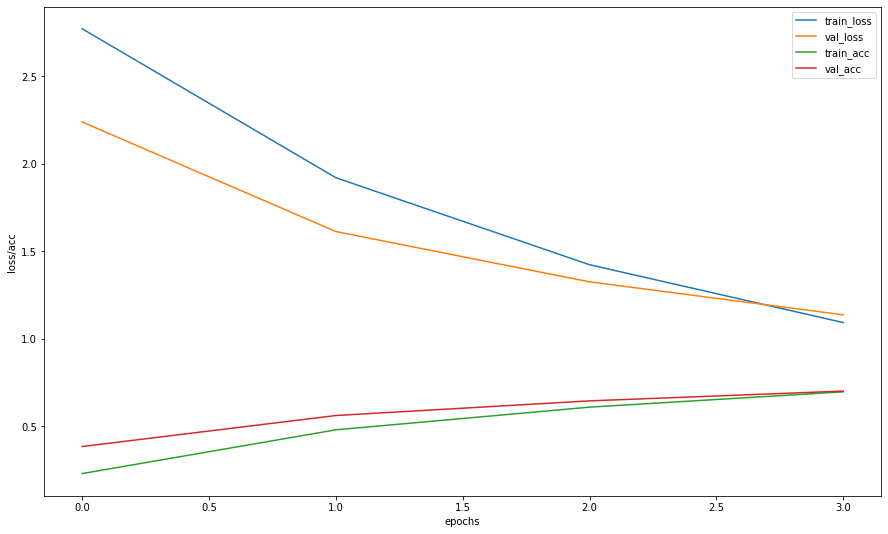

In [235]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc") # [i.cpu().numpy() for i in val_acc]
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/acc")
plt.show()

In [13]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [168]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [64]:
idxs = list(map(int, np.random.uniform(0,len(val_dataset), 1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

f1 = f1_score(actual_labels, y_pred, average='weighted')
f1

0.846876544853183

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(m2_opt, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred].split('_')
    predicted_label = '_'.join(predicted_label[:-1]) + '_\n' + str(predicted_label[-1]) # [:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [149]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(mdl, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv(f'SUBMIT_{mdl}_Hf_{epochs}_{batch_size}.csv', index=False)


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

[alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


## Непростая модель

In [ ]:
# BnCnn - модель с batchnorm
# BnCnn_Deep1 - модель с batchnorm и дополнительным fce слоем
# BnCnn_Deep3 - модель с batchnorm и дополнительными 3 fce слоем
# BnCnn_Deep1_d25 - модель с batchnorm и дополнительными fce слоем и dropout

In [15]:
class BnCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
class BnCnn_Deep1(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fce1 = nn.Sequential(
            nn.Linear(96*5*5, 96*5*5),
            nn.ReLU(),
            nn.BatchNorm1d(96*5*5)
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fce1(x)
        logits = self.out(x)
        return logits

In [17]:
class BnCnn_Deep3(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fce1 = nn.Sequential(
            nn.Linear(96*5*5, 64*5*5),
            nn.ReLU(),
            nn.BatchNorm1d(64*5*5)
        )
        self.fce2 = nn.Sequential(
            nn.Linear(64*5*5, 32*5*5),
            nn.ReLU(),
            nn.BatchNorm1d(32*5*5)
        )
        self.fce3 = nn.Sequential(
            nn.Linear(32*5*5, 16*5*5),
            nn.ReLU(),
            nn.BatchNorm1d(16*5*5)
        )
        self.out = nn.Linear(16*5*5, n_classes)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fce1(x)
        x = self.fce2(x)
        x = self.fce3(x)
        logits = self.out(x)
        return logits

In [18]:
class BnCnn_Deep1_d25(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fce1 = nn.Sequential(
            nn.Linear(96*5*5, 96*5*5),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fce1(x)
        logits = self.out(x)
        return logits

In [19]:
def model_check(model, epochs, batch_size, opt=False):
    model = model(n_classes).to(DEVICE)
    mdl = model.__class__.__name__ if opt == False else model.__class__.__name__+'_opt'

    val_dataset = SimpsonsDataset(val_files, mode='val')
    train_dataset = SimpsonsDataset(train_files, mode='train')

    history = train(train_dataset, val_dataset, model=model, epochs=epochs, batch_size=batch_size)

    loss, acc, val_loss, val_acc = zip(*history)
    fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
    ax[0].plot(loss, label="train_loss")
    ax[0].plot(val_loss, label="val_loss")
    ax[1].plot(acc, label="train_acc")
    ax[1].plot(val_acc, label="val_acc") 
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[1].set_ylabel("acc")
    plt.title(f'{mdl} with batch size:{batch_size} on {epochs} epochs')
    plt.show()

    idxs = list(map(int, np.random.uniform(0,len(val_dataset), 1000)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = [label_encoder.classes_[i] for i in y_pred]
    f1 = f1_score(actual_labels, y_pred, average='weighted')
    print(f'f-score: {f1}')

    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]
    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    my_submit.to_csv(f'Simpsons_models/SUBMIT_{mdl}_Hf_{epochs}_{batch_size}.csv', index=False)

    torch.save(model, f'Simpsons_models/{mdl}.pth')
    torch.save(model.state_dict(), f'Simpsons_models/{mdl}_Hf_{epochs}_{batch_size}.pth')
    return model

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7891 val_loss 1.4008 train_acc 0.5226 val_acc 0.6167

Epoch 002 train_loss: 1.0463 val_loss 1.0942 train_acc 0.7101 val_acc 0.7012

Epoch 003 train_loss: 0.7633 val_loss 0.8929 train_acc 0.7849 val_acc 0.7667

Epoch 004 train_loss: 0.5709 val_loss 0.7961 train_acc 0.8403 val_acc 0.7998

Epoch 005 train_loss: 0.4296 val_loss 0.7927 train_acc 0.8780 val_acc 0.7921

Epoch 006 train_loss: 0.3573 val_loss 0.8145 train_acc 0.8988 val_acc 0.8015

Epoch 007 train_loss: 0.3154 val_loss 0.7723 train_acc 0.9083 val_acc 0.8187

Epoch 008 train_loss: 0.2482 val_loss 0.8257 train_acc 0.9260 val_acc 0.8086

Epoch 009 train_loss: 0.2112 val_loss 0.8337 train_acc 0.9361 val_acc 0.8196

Epoch 010 train_loss: 0.1785 val_loss 0.7917 train_acc 0.9460 val_acc 0.8277


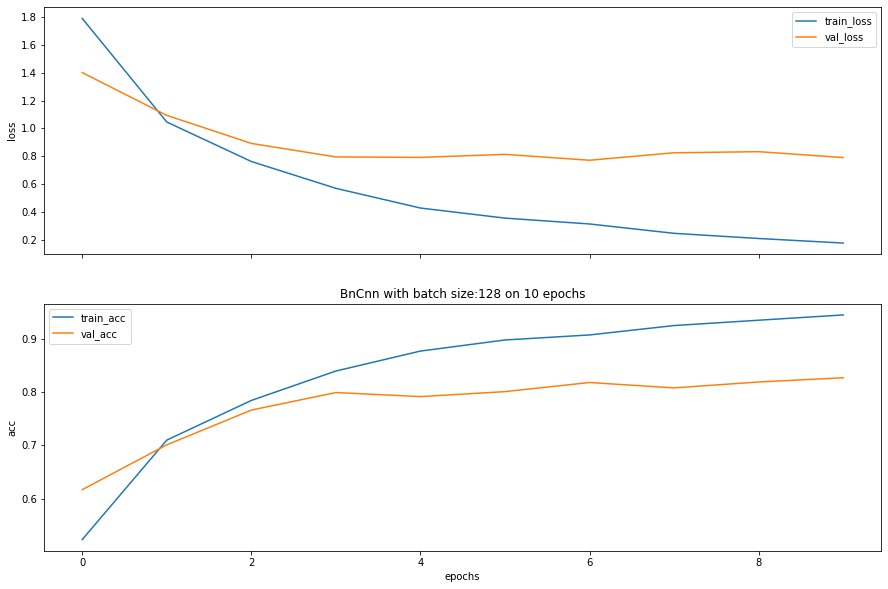

f-score: 0.863703628528209


In [19]:
m = model_check(BnCnn, 10, 128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7780 val_loss 1.2483 train_acc 0.5548 val_acc 0.6716

Epoch 002 train_loss: 0.9802 val_loss 0.9659 train_acc 0.7334 val_acc 0.7449

Epoch 003 train_loss: 0.6153 val_loss 0.9368 train_acc 0.8291 val_acc 0.7554

Epoch 004 train_loss: 0.4592 val_loss 0.7999 train_acc 0.8694 val_acc 0.8034

Epoch 005 train_loss: 0.2907 val_loss 0.8227 train_acc 0.9144 val_acc 0.8152

Epoch 006 train_loss: 0.2147 val_loss 0.8763 train_acc 0.9362 val_acc 0.8231

Epoch 007 train_loss: 0.2322 val_loss 0.9974 train_acc 0.9329 val_acc 0.8084

Epoch 008 train_loss: 0.2446 val_loss 1.0520 train_acc 0.9267 val_acc 0.8059

Epoch 009 train_loss: 0.1896 val_loss 1.2412 train_acc 0.9438 val_acc 0.8002

Epoch 010 train_loss: 0.1791 val_loss 1.0563 train_acc 0.9499 val_acc 0.8292


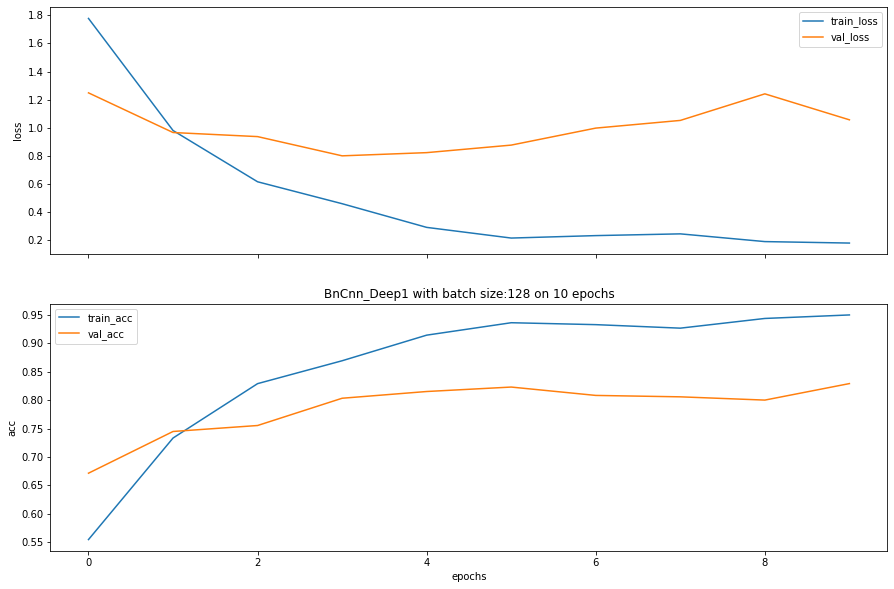

f-score: 0.801930918141693


In [34]:
m2 = model_check(BnCnn_Deep1, 10, 128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7651 val_loss 1.2567 train_acc 0.5584 val_acc 0.6647

Epoch 002 train_loss: 1.0442 val_loss 0.9454 train_acc 0.7128 val_acc 0.7400

Epoch 003 train_loss: 0.7290 val_loss 0.8103 train_acc 0.7981 val_acc 0.7784

Epoch 004 train_loss: 0.5630 val_loss 0.7782 train_acc 0.8441 val_acc 0.7881

Epoch 005 train_loss: 0.4637 val_loss 0.7047 train_acc 0.8693 val_acc 0.8112

Epoch 006 train_loss: 0.3741 val_loss 0.6558 train_acc 0.8948 val_acc 0.8216

Epoch 007 train_loss: 0.3045 val_loss 0.6577 train_acc 0.9136 val_acc 0.8202

Epoch 008 train_loss: 0.2662 val_loss 0.6447 train_acc 0.9253 val_acc 0.8286

Epoch 009 train_loss: 0.2104 val_loss 0.5971 train_acc 0.9419 val_acc 0.8502

Epoch 010 train_loss: 0.1631 val_loss 0.5798 train_acc 0.9538 val_acc 0.8479


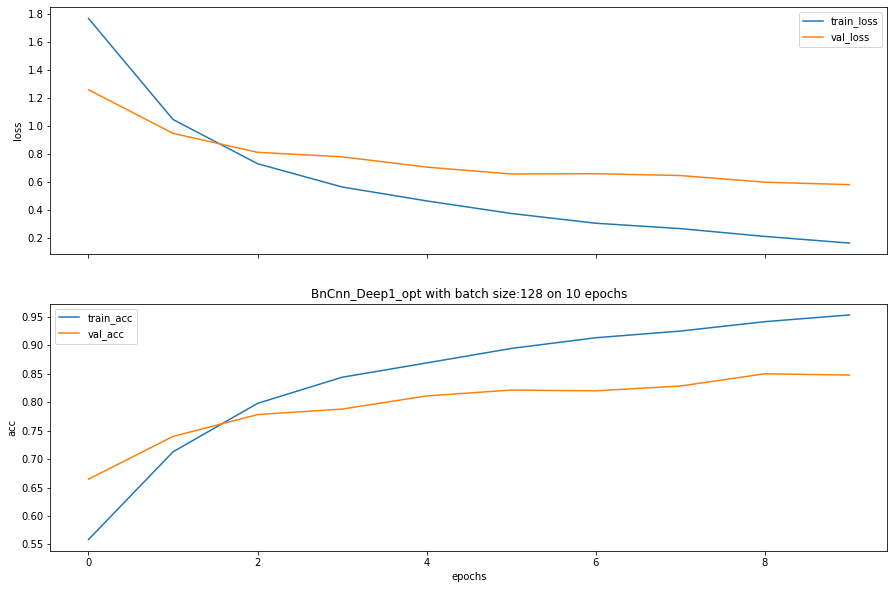

f-score: 0.8501692599301969


In [53]:
# _opt means adding schedeler and weight_decay in optimaser in train function
m2_opt = model_check(BnCnn_Deep1, 10, 128, opt=True)
# 0.92879

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7569 val_loss 1.2316 train_acc 0.5541 val_acc 0.6664

Epoch 002 train_loss: 1.0075 val_loss 0.9263 train_acc 0.7205 val_acc 0.7503

Epoch 003 train_loss: 0.7027 val_loss 0.7196 train_acc 0.8030 val_acc 0.8017

Epoch 004 train_loss: 0.5605 val_loss 0.7281 train_acc 0.8430 val_acc 0.8036

Epoch 005 train_loss: 0.4702 val_loss 0.5819 train_acc 0.8653 val_acc 0.8351

Epoch 006 train_loss: 0.3843 val_loss 0.6086 train_acc 0.8911 val_acc 0.8319

Epoch 007 train_loss: 0.3250 val_loss 0.5495 train_acc 0.9087 val_acc 0.8508

Epoch 008 train_loss: 0.2666 val_loss 0.5585 train_acc 0.9247 val_acc 0.8489

Epoch 009 train_loss: 0.2285 val_loss 0.6228 train_acc 0.9367 val_acc 0.8344

Epoch 010 train_loss: 0.2000 val_loss 0.5728 train_acc 0.9477 val_acc 0.8540

Epoch 011 train_loss: 0.1485 val_loss 0.5713 train_acc 0.9618 val_acc 0.8561

Epoch 012 train_loss: 0.1247 val_loss 0.5350 train_acc 0.9688 val_acc 0.8626

Epoch 013 train_loss: 0.1057 val_loss 0.5493 train_acc 0.9743 v

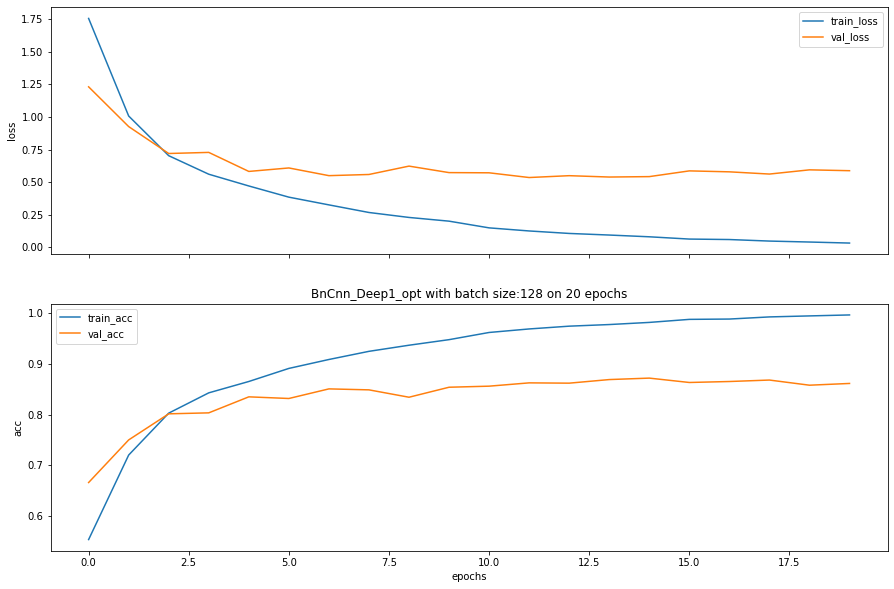

f-score: 0.8500620106640309


In [24]:
m2_opt_20 = model_check(BnCnn_Deep1, 20, 128, opt=True)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.9921 val_loss 1.3487 train_acc 0.4784 val_acc 0.6368

Epoch 002 train_loss: 1.0065 val_loss 1.0166 train_acc 0.7140 val_acc 0.7251

Epoch 003 train_loss: 0.6392 val_loss 0.8296 train_acc 0.8162 val_acc 0.7812

Epoch 004 train_loss: 0.3961 val_loss 0.8622 train_acc 0.8840 val_acc 0.7875

Epoch 005 train_loss: 0.2822 val_loss 0.7867 train_acc 0.9174 val_acc 0.8217

Epoch 006 train_loss: 0.2046 val_loss 0.8530 train_acc 0.9376 val_acc 0.8210

Epoch 007 train_loss: 0.1744 val_loss 0.8576 train_acc 0.9467 val_acc 0.8160

Epoch 008 train_loss: 0.1401 val_loss 0.9376 train_acc 0.9572 val_acc 0.8238

Epoch 009 train_loss: 0.1218 val_loss 0.9426 train_acc 0.9652 val_acc 0.8181

Epoch 010 train_loss: 0.1069 val_loss 1.0705 train_acc 0.9692 val_acc 0.8309


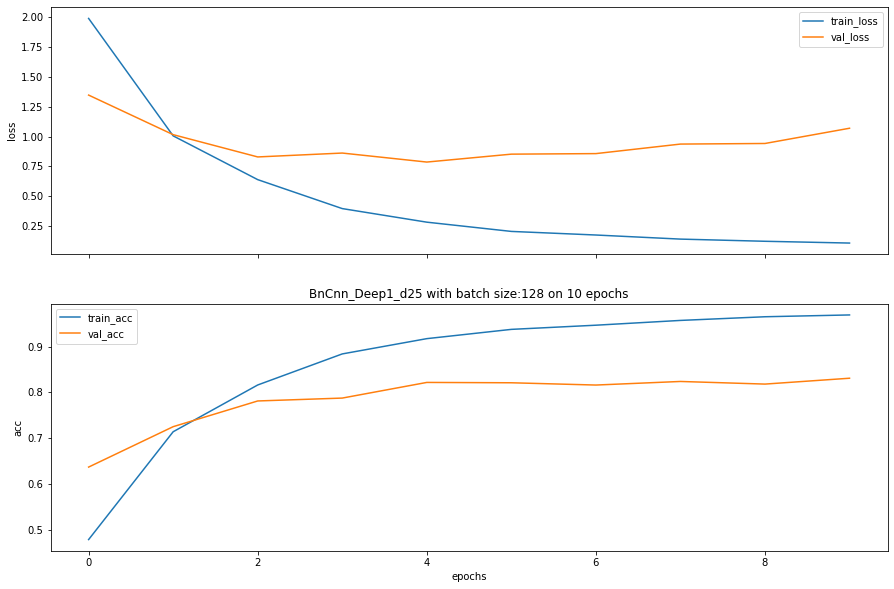

f-score: 0.8095857386477169


BnCnn_Deep1_d25(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [37]:
m3 = model_check(BnCnn_Deep1_d25, 10, 128)
# 0.92667

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.9296 val_loss 1.2777 train_acc 0.4920 val_acc 0.6418

Epoch 002 train_loss: 1.0638 val_loss 0.9355 train_acc 0.7028 val_acc 0.7438

Epoch 003 train_loss: 0.8037 val_loss 0.8465 train_acc 0.7735 val_acc 0.7673

Epoch 004 train_loss: 0.6828 val_loss 0.7657 train_acc 0.8029 val_acc 0.7835

Epoch 005 train_loss: 0.5879 val_loss 0.7182 train_acc 0.8350 val_acc 0.8009

Epoch 006 train_loss: 0.5191 val_loss 0.6604 train_acc 0.8544 val_acc 0.8103

Epoch 007 train_loss: 0.4613 val_loss 0.6223 train_acc 0.8651 val_acc 0.8300

Epoch 008 train_loss: 0.4065 val_loss 0.6263 train_acc 0.8855 val_acc 0.8279

Epoch 009 train_loss: 0.3724 val_loss 0.5846 train_acc 0.8929 val_acc 0.8401

Epoch 010 train_loss: 0.3120 val_loss 0.5797 train_acc 0.9112 val_acc 0.8418


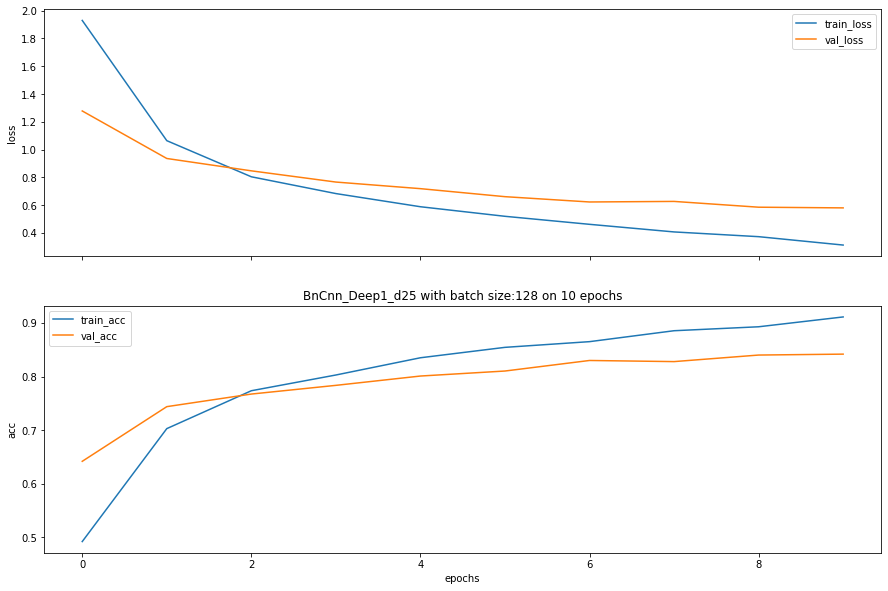

f-score: 0.8511439291768638


In [34]:
m3_opt = model_check(BnCnn_Deep1_d25, 10, 128, opt=True)
# 0.90541

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7947 val_loss 1.1837 train_acc 0.5252 val_acc 0.6691

Epoch 002 train_loss: 1.0171 val_loss 0.9012 train_acc 0.7104 val_acc 0.7468

Epoch 003 train_loss: 0.7678 val_loss 0.7783 train_acc 0.7809 val_acc 0.7831

Epoch 004 train_loss: 0.6362 val_loss 0.6931 train_acc 0.8195 val_acc 0.8082

Epoch 005 train_loss: 0.5529 val_loss 0.6669 train_acc 0.8455 val_acc 0.8137

Epoch 006 train_loss: 0.4981 val_loss 0.6259 train_acc 0.8597 val_acc 0.8221

Epoch 007 train_loss: 0.4216 val_loss 0.5808 train_acc 0.8815 val_acc 0.8414

Epoch 008 train_loss: 0.3914 val_loss 0.5846 train_acc 0.8890 val_acc 0.8359

Epoch 009 train_loss: 0.3433 val_loss 0.5297 train_acc 0.9031 val_acc 0.8565

Epoch 010 train_loss: 0.2945 val_loss 0.5931 train_acc 0.9172 val_acc 0.8426

Epoch 011 train_loss: 0.2680 val_loss 0.5447 train_acc 0.9231 val_acc 0.8563

Epoch 012 train_loss: 0.2302 val_loss 0.5559 train_acc 0.9362 val_acc 0.8565

Epoch 013 train_loss: 0.1863 val_loss 0.5524 train_acc 0.9501 v

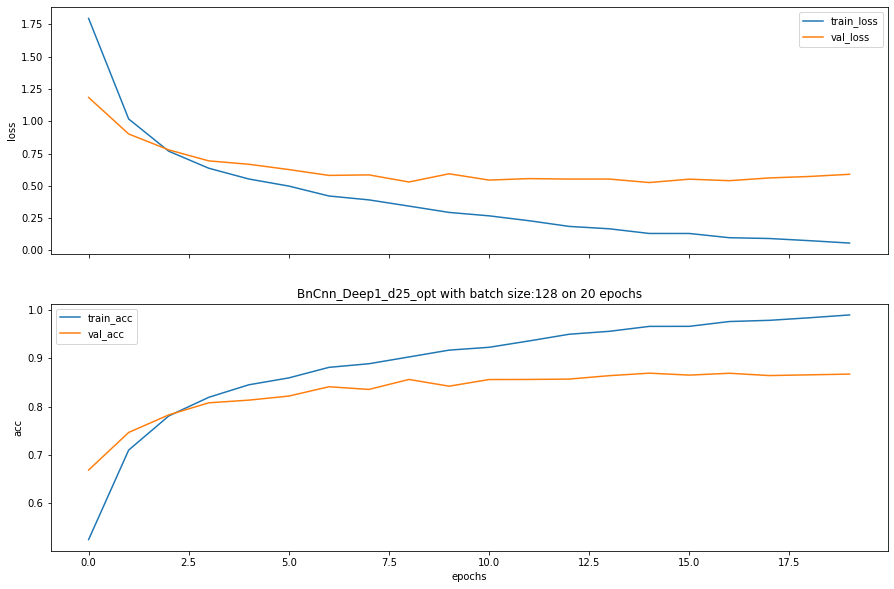

f-score: 0.8699077346876031


In [23]:
m3_opt_20 = model_check(BnCnn_Deep1_d25, 20, 128, opt=True)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.8339 val_loss 1.4818 train_acc 0.5261 val_acc 0.6037

Epoch 002 train_loss: 1.1903 val_loss 1.1648 train_acc 0.6733 val_acc 0.6708

Epoch 003 train_loss: 0.9363 val_loss 0.9375 train_acc 0.7355 val_acc 0.7237

Epoch 004 train_loss: 0.7667 val_loss 0.7818 train_acc 0.7825 val_acc 0.7853

Epoch 005 train_loss: 0.6474 val_loss 0.7558 train_acc 0.8183 val_acc 0.7910

Epoch 006 train_loss: 0.5775 val_loss 0.8331 train_acc 0.8390 val_acc 0.7749

Epoch 007 train_loss: 0.5187 val_loss 0.6692 train_acc 0.8541 val_acc 0.8147

Epoch 008 train_loss: 0.4545 val_loss 0.6696 train_acc 0.8743 val_acc 0.8175

Epoch 009 train_loss: 0.4117 val_loss 0.6350 train_acc 0.8832 val_acc 0.8290

Epoch 010 train_loss: 0.3680 val_loss 0.6571 train_acc 0.9000 val_acc 0.8263


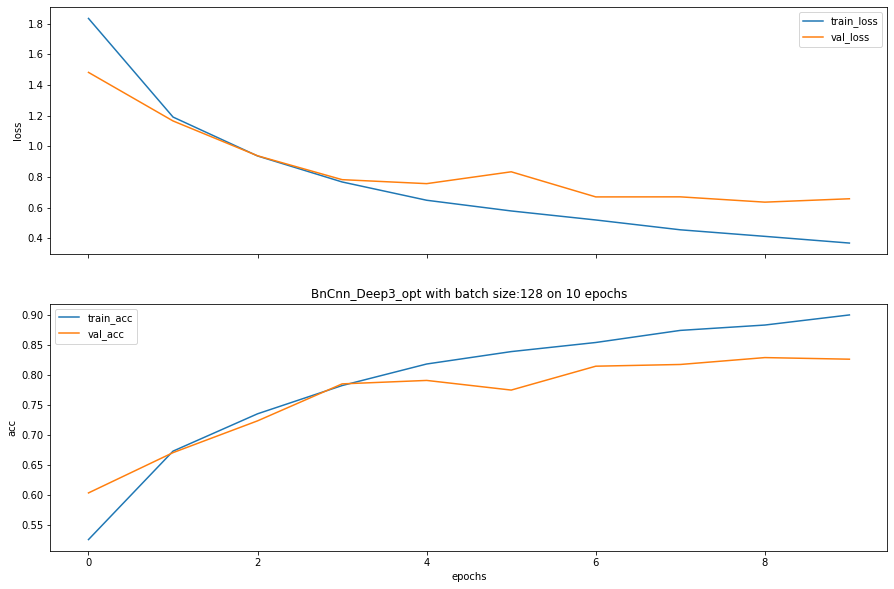

f-score: 0.8387249441018668


In [19]:
m4_opt = model_check(BnCnn_Deep3, 10, 128, opt=True)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7573 val_loss 1.3529 train_acc 0.5453 val_acc 0.6286

Epoch 002 train_loss: 1.1492 val_loss 1.0216 train_acc 0.6834 val_acc 0.7107

Epoch 003 train_loss: 0.8796 val_loss 0.8406 train_acc 0.7553 val_acc 0.7703

Epoch 004 train_loss: 0.7377 val_loss 0.7688 train_acc 0.7927 val_acc 0.7874

Epoch 005 train_loss: 0.6282 val_loss 0.6946 train_acc 0.8222 val_acc 0.8057

Epoch 006 train_loss: 0.5484 val_loss 0.7032 train_acc 0.8491 val_acc 0.8003

Epoch 007 train_loss: 0.4892 val_loss 0.6234 train_acc 0.8641 val_acc 0.8347

Epoch 008 train_loss: 0.4338 val_loss 0.6007 train_acc 0.8815 val_acc 0.8378

Epoch 009 train_loss: 0.3883 val_loss 0.6489 train_acc 0.8945 val_acc 0.8248

Epoch 010 train_loss: 0.3517 val_loss 0.5720 train_acc 0.9060 val_acc 0.8489

Epoch 011 train_loss: 0.3283 val_loss 0.5785 train_acc 0.9119 val_acc 0.8475

Epoch 012 train_loss: 0.2931 val_loss 0.6053 train_acc 0.9219 val_acc 0.8408

Epoch 013 train_loss: 0.2653 val_loss 0.5781 train_acc 0.9283 v

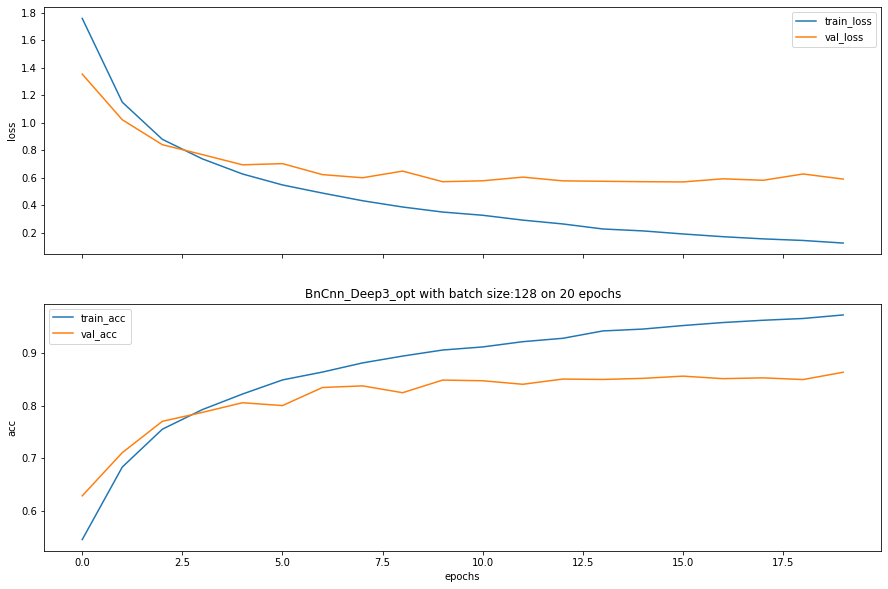

f-score: 0.8731152597378521


In [25]:
m4_opt_20 = model_check(BnCnn_Deep3, 20, 128, opt=True)
# 0.94792

epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.8632 val_loss 1.4424 train_acc 0.5292 val_acc 0.6144

Epoch 002 train_loss: 1.1041 val_loss 1.1015 train_acc 0.6906 val_acc 0.6821

Epoch 003 train_loss: 0.8302 val_loss 0.9775 train_acc 0.7667 val_acc 0.7337

Epoch 004 train_loss: 0.6728 val_loss 0.8402 train_acc 0.8092 val_acc 0.7602

Epoch 005 train_loss: 0.5704 val_loss 0.7174 train_acc 0.8369 val_acc 0.8068

Epoch 006 train_loss: 0.4716 val_loss 0.7420 train_acc 0.8672 val_acc 0.8024

Epoch 007 train_loss: 0.3928 val_loss 0.6774 train_acc 0.8908 val_acc 0.8154

Epoch 008 train_loss: 0.3180 val_loss 0.6387 train_acc 0.9122 val_acc 0.8323

Epoch 009 train_loss: 0.2614 val_loss 0.6522 train_acc 0.9291 val_acc 0.8248

Epoch 010 train_loss: 0.2258 val_loss 0.6098 train_acc 0.9395 val_acc 0.8451

Epoch 011 train_loss: 0.1841 val_loss 0.6307 train_acc 0.9537 val_acc 0.8393

Epoch 012 train_loss: 0.1565 val_loss 0.6112 train_acc 0.9617 val_acc 0.8504

Epoch 013 train_loss: 0.1336 val_loss 0.5990 train_acc 0.9684 v

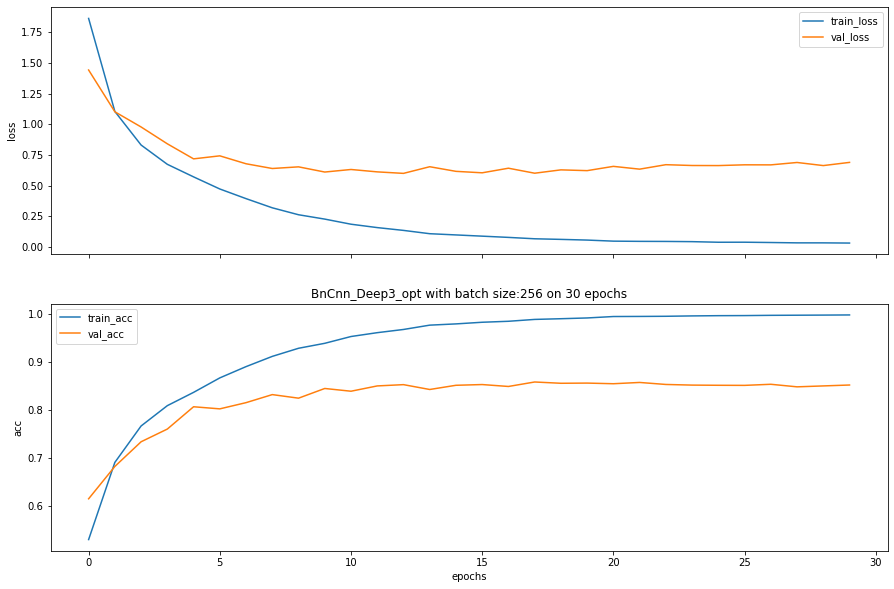

f-score: 0.8555612373933097


In [20]:
m4_opt_30 = model_check(BnCnn_Deep3, 30, 256, opt=True)

In [30]:
# Загрузка модели и весов наилучшей модели
m3_opt = BnCnn_Deep3(n_classes).to(DEVICE)
m3_opt.load_state_dict(torch.load('BnCnn_Deep3_opt_Hf_20_128.pth'))

<All keys matched successfully>